In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.models.tvqregularized import TVqRegularized
from bimpcc.models.tvq_denoising import TVDenoisingMPCC
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from bimpcc.utils import generate_2D_gradient_matrices

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 4

In [5]:
dataset = get_dataset("cameraman",scale=scale)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(3.5), np.float64(3.5), np.float64(-0.5))

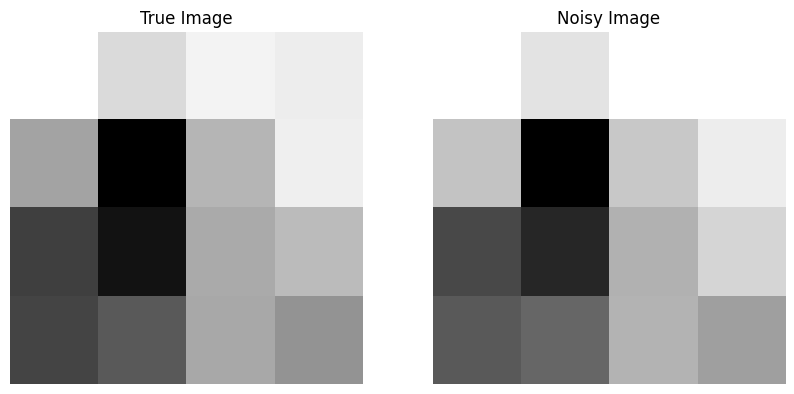

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [7]:
model = TVqRegularized(true, noisy, epsilon=1e-3, q_param=0.99)

In [8]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      290
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       41
                     variables with only lower bounds:       17
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       40
Total number of inequality c

In [9]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

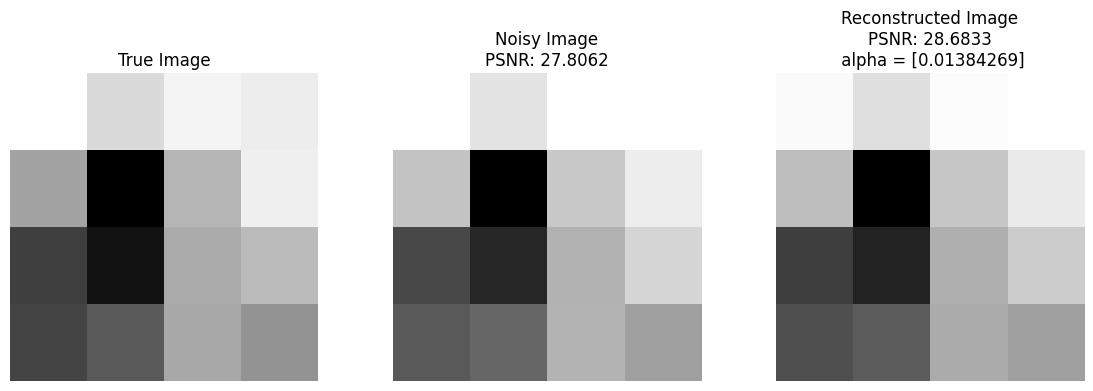

In [10]:
u = u.reshape((scale,scale))
plot_experiment(true,noisy,u,alpha)

In [11]:
Kx, Ky, K = generate_2D_gradient_matrices(scale)

In [12]:
m = q.flatten().size
n = m // 2

Ku = K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ

In [13]:
Kxu = Ku[:n]  # Primeras n componentes
Kyu = Ku[n:]  # Últimas n componentes
qx = q[:n]  # Primeras n componentes
qy = q[n:]  # Últimas n componentes
epsilon = 1e-10  

# Condiciones para calcular theta según los casos dados
theta0 = np.zeros(n)  # Inicializamos theta0

# Caso 1: r_i ≠ 0
mask_r_nonzero = r0 > epsilon
theta0[mask_r_nonzero] = np.arccos(Kxu[mask_r_nonzero] / r0[mask_r_nonzero])
theta0[mask_r_nonzero & (Kyu < 0)] *= -1  # Si Ky^i u < 0, negamos theta0

# Caso 2: r_i = 0 y delta_i ≠ 0
mask_r_zero_delta_nonzero = (r0 <= epsilon) & (delta0 > epsilon)
theta0[mask_r_zero_delta_nonzero] = np.arccos(qx[mask_r_zero_delta_nonzero] / delta0[mask_r_zero_delta_nonzero])
theta0[mask_r_zero_delta_nonzero & (qy < 0)] *= -1  # Si qy^i < 0, negamos theta0

# Caso 3: r_i = 0 y delta_i = 0 (theta0 indefinido)
mask_r_zero_delta_zero = (r0 <= epsilon) & (delta0 <= epsilon)
theta0[mask_r_zero_delta_zero] = 0

In [14]:
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,theta0,alpha))
# print(x0_mpcc)

In [15]:
mpcc_model = TVDenoisingMPCC(true, noisy, x0=x0_mpcc, epsilon=1e-3, q_param = 0.99)

In [16]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=100,tol=1e-4,print_level=5,verbose=True)

Iter   Termination_status            Objective      MPCC_compl               t

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0833336e-02 8.31e-08 7.50e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

0                 0  0.005108439601124847    1.3256676467880115                 1.0

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.1084396e-03 3.48e-01 8.17e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

1                 0  0.005111090883544839    1.3245017545181859                 0.5

  33  5.1110878e-03 6.86e-08 8.18e-08 -11.0 4.69e-06    -  1.00e+00 1.00e+00h  1
  34  5.1110893e-03 1.95e-08 1.90e-08 -11.0 1.64e-06    -  1.00e+00 1.00e+00h  1
  35  5.1110906e-03 4.78e-09 1.26e-08 -11.0 5.15e-07    -  1.00e+00 1.00e+00h  1
  36  5.1110904e-03 2.44e-08 2.64e-08 -11.0 1.02e-06    -  1.00e+00 1.00e+00h  1
  37  5.1110909e-03 3.40e-10 6.17e-09 -11.0 4.72e-07    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   5.1110908835448393e-03    5.1110908835448393e-03
Dual infeasibility......:   6.1698211568826200e-09    6.1698211568826200e-09
Constraint violation....:   3.4006475153197657e-10    3.4006475153197657e-10
Variable bound violation:   8.8626587319007299e-09    8.8626587319007299e-09
Complementarity.........:   1.0000000000000003e-11    1.0000000000000003e-11
Overall NLP error.......:   6.1698211568826200e-09    6.1698211568826200e-09


Number of objective function 

2                 0  0.005248400290725421    0.8789048113163592                0.25

ation....:   5.7706996126061227e-10    5.7706996126061227e-10
Variable bound violation:   9.4414867844467426e-09    9.4414867844467426e-09
Complementarity.........:   1.0000000000000001e-11    1.0000000000000001e-11
Overall NLP error.......:   3.3125138695219771e-09    3.3125138695219771e-09


Number of objective function evaluations             = 40
Number of objective gradient evaluations             = 32
Number of equality constraint evaluations            = 40
Number of inequality constraint evaluations          = 40
Number of equality constraint Jacobian evaluations   = 32
Number of inequality constraint Jacobian evaluations = 32
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.403

EXIT: Optimal Solution Found.
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number o

3                 0  0.005468117606692396    0.5399648818081856               0.125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.4681176e-03 5.70e-02 7.14e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

4                 0  0.005639484002734126    0.27428272260823505             0.0625

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.6394840e-03 2.44e-02 7.33e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

5                 0  0.005767793983925242    0.12879043777530738            0.03125

r of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.304

EXIT: Optimal Solution Found.
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    object

6                 0  0.006052535857072459    0.0936373217127188            0.015625

ity constraint evaluations          = 26
Number of equality constraint Jacobian evaluations   = 26
Number of inequality constraint Jacobian evaluations = 26
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.321

EXIT: Optimal Solution Found.
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lowe

7                 0  0.006487913548329885    0.07193923746803808          0.0078125

  15  6.4879135e-03 6.35e-11 1.08e-09 -11.0 1.10e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   6.4879135483298846e-03    6.4879135483298846e-03
Dual infeasibility......:   1.0777932206688121e-09    1.0777932206688121e-09
Constraint violation....:   6.3463581612133169e-11    6.3463581612133169e-11
Variable bound violation:   9.6075518909912588e-09    9.6075518909912588e-09
Complementarity.........:   1.0000000000971428e-11    1.0000000000971428e-11
Overall NLP error.......:   1.0777932206688121e-09    1.0777932206688121e-09


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 16
Number of inequality constraint evaluations          = 16
Number of equality constraint Jacobian evaluations   = 16
Number of inequality constraint Jacobian evaluations = 16
Numbe

8                 0  0.007666951179789476    0.04935945084027469         0.00390625

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.6669512e-03 9.16e-03 7.47e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

9                 0  0.0089133300999142      0.026776355854619533       0.001953125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.9133301e-03 7.48e-03 7.50e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

10                 0  0.0097905443559125      0.013649061174649478      0.0009765625

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.7905444e-03 2.74e-03 7.51e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

11                 0  0.010287598447955805    0.0068928301198049385    0.00048828125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0287598e-02 2.89e-04 7.51e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

12                 0  0.010553626989158035    0.003485371202130709    0.000244140625

valuations   = 13
Number of inequality constraint Jacobian evaluations = 13
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.173

EXIT: Optimal Solution Found.
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        

13                 0  0.010691709155603234    0.0017527918695065398   0.0001220703125

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0691709e-02 6.10e-05 7.50e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

14                 0  0.010762067915807012    0.0008790201262138395   6.103515625e-05

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0762068e-02 3.05e-05 7.50e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

15                 0  0.010797583744264112    0.0004402256650519515   3.0517578125e-05

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      326
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       77
                     variables with only lower bounds:       41
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       64
Total number of inequality constraints...............:       24
        inequality constraints with only lower bounds:       24
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0797584e-02 1.53e-05 7.50e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

16                 0  0.010815426767517261    0.0002203462134263708   1.52587890625e-05

r of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 0.162

EXIT: Optimal Solution Found.


Intermediate result:  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the 
convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 0.010815426767517261
       x: [ 9.817e-01  8.968e-01 ... -1.825e+00  1.387e-02]
     nit: 11
    info:     status: 0
                   x: [ 9.817e-01  8.968e-01 ... -1.825e+00  1.387e-02]
                   g: [ 7.363e-05 -9.208e-09 ...  2.195e-13  6.591e-14]
             obj_val: 0.010815426767517261
              mult_g: [-1.356e-07 -1.263e-02 ... -8.373e-03 -1.708e-02]
            mult_x_L: [ 1.019e-11  1.115e-11 ...  0.000e+00  7.209e-10]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence 
tolerances (can be specified by options).'
    nfev: 12
    njev: 13

Intermediate fn: 0.010815426767517261

complementarity: 0.00022034621342637082

* (STOPPED) Iteration 18: Solving the NLP problem for t = 1e-05 with complementarity: 0.0002203462134263708

In [17]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = mpcc_model.objective_func.parse_vars(x_opt_mpcc)

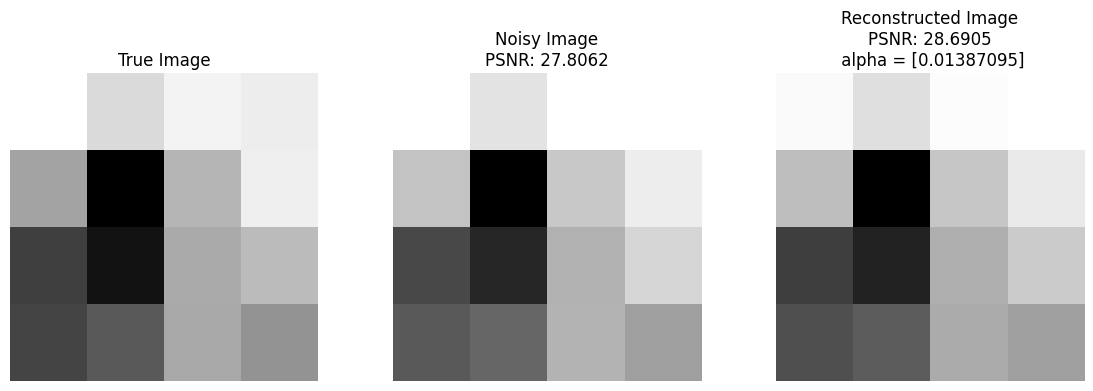

In [18]:
u_mpcc = u_mpcc.reshape((scale,scale))
plot_experiment(true,noisy,u_mpcc,alpha_mpcc)